<span style="font-family:Calibri; font-size:3em;">Handwritten Digits Classifier</span>

<span style="font-family:Calibri; font-size:1.5em;">A guided project with UCI data set</span>

![Image](https://cdn-images-1.medium.com/max/2400/1*LmxW8FDfXZJl5yvESvjP7Q.jpeg)

## Introduction

In this project, we'll explore different approaches to image classification using traditional machine learning algorithms and deep learning.

We'll be working with [hand-written digits dataset](http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits) from UCI. Luckily the `sklearn` library has built-in function that returns the exact copy.

In [1]:
from sklearn.datasets import load_digits
digits = load_digits(as_frame=True)
print(digits.data.shape)

(1797, 64)


In [2]:
digits.frame.head()

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7,target
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4


The data set has **1797** images are represented as a row of pixel values. Since each row contain **64** values our images have **8x8** resolution.

Let's display some of them using `matplotlib`.

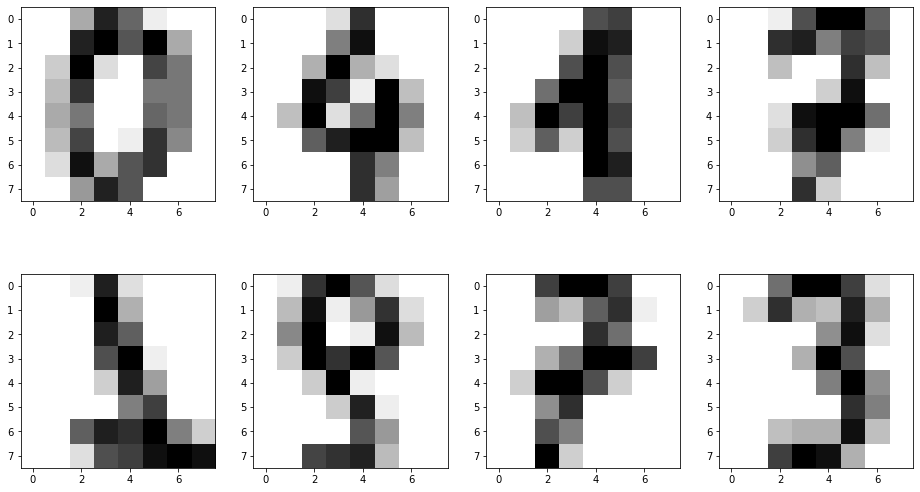

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

fix, axs = plt.subplots(2, 4, figsize=(16,9))
digits_df = digits.data
bias = 0

for row in range(2):
    for col in range(4):
        #Calculate index for each image
        #It would be 1100 for second bottom image for exaple 
        index = col * 100 + bias
        image = digits_df.iloc[index].values.reshape(8,8)
        axs[row, col].imshow(image, cmap='gray_r')
        
    bias = 1000

## KNN classifier

Due to there is no linearity between image's pixels and an actiual digit we'll use the k-nearest neighbors algorithm here. The `KNeighborsClassifier` to be precise.

Let's define a few functions and run them with **k=5** and **folds=4**.

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

def train_test(train_set, test_set, k, how='train'):
    #trains and tests k-nearest neighbors models with different k
    
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(train_set.iloc[:, :-1], train_set['target'])
    
    #uses train or test sets in predict() depending on how
    if how == 'train':
        prediction = knn.predict(train_set.iloc[:, :-1])
        accuracy = accuracy_score(train_set['target'], prediction)
        return accuracy
    
    elif how == 'test':
        prediction = knn.predict(test_set.iloc[:, :-1])
        accuracy = accuracy_score(test_set['target'], prediction)
        return accuracy
    
def cross_validate(data, k, how='train'):
    #performs 4-fold cross validation using train() and test()
    #returns overall accuracy
    
    kf = KFold(n_splits=4,
              shuffle=True,
              random_state=0)
    
    accuracies = []
    
    for train_index, test_index in kf.split(data):
        
        train_set = data.iloc[train_index]
        test_set = data.iloc[test_index]

        accuracy = train_test(train_set, test_set, k, how)
        accuracies.append(accuracy)
        
    return np.mean(accuracies)

cross_validate(digits.frame, 5)

0.990725350762988

Now let's iterate number of neigbors and build a plot for computed accuracies.

In [5]:
knn_accuracies = pd.DataFrame(index=range(1,36), columns=['train', 'test'])

methods = ['train', 'test']

#Iterate over both methods and 25 neigbors numbers
for how in methods:
    for k in range(1,36):
        accuracy = cross_validate(digits.frame, k, how)
        knn_accuracies.loc[k, how] = accuracy
    
knn_accuracies.tail(10)

,train,test
26,0.968466,0.966616
27,0.967724,0.964946
28,0.966796,0.964389
29,0.967539,0.963832
30,0.966982,0.964947
31,0.966055,0.964947
32,0.965127,0.963276
33,0.964942,0.962163
34,0.9642,0.961605
35,0.963829,0.959379


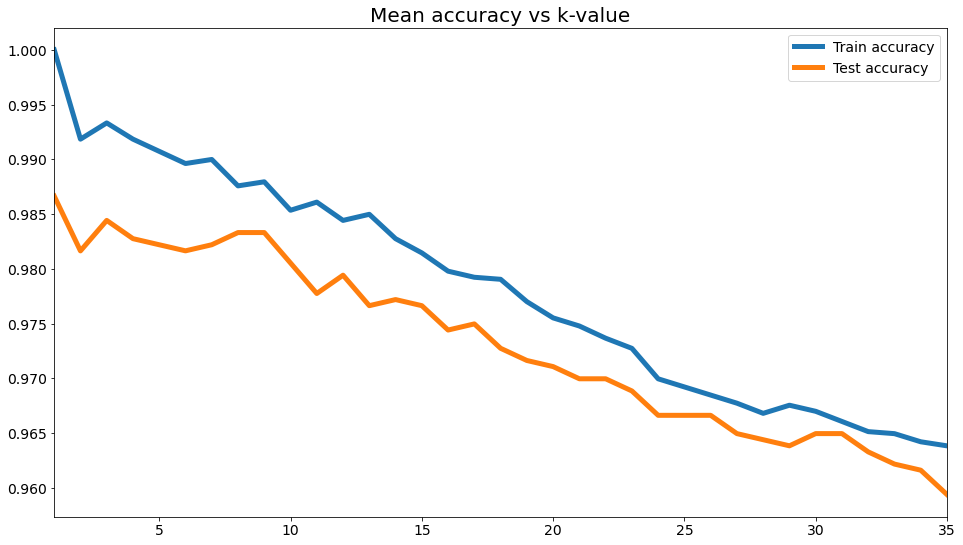

In [6]:
fig, ax = plt.subplots(figsize=(16,9))

for col in knn_accuracies.columns:
    ax.plot(knn_accuracies[col],
           lw=5)

#decorations
ax.set_xlim(1, 35)
ax.set_title('Mean accuracy vs k-value', fontsize=20)
ax.tick_params(labelsize=14)
ax.legend(['Train accuracy', 'Test accuracy'],
         fontsize=14)

It seems the best result's achived with **k=1**, **0.986** on test set and **1** on train. Both accurasies are extreamly high due to we use in-build dataset. Also increasing k-value doesn't make our predictions more accurate.

Also we can observe the difference between train and test accuracies which is signal of overfitting. But increasing k-value decreases this difference. For example, with **k=25** we'got **0.969** and	**0.966** for train and test sets respectively.

We'll stick to these results and try to improve this result with neural network.

## MLP classifier

There are a few downsides to using k-nearest neighbors:
* high memory usage (for each new unseen observation, many comparisons need to be made to seen observations)
* no model representation to debug and explore

Considering this we'll try a neural network with a single hidden layer but with different number of neurons. We'll keep using cross validation with 4 folds at this try as well.

In [7]:
from sklearn.neural_network import MLPClassifier

def mlp_cross_val(data, n):
    #performs 4-fold cross validation using MLPClassifier
    #returns overall accuracies
    
    kf = KFold(n_splits=4,
              shuffle=True,
              random_state=0)
    
    train_accuracies = []
    test_accuracies = []
    
    for train_index, test_index in kf.split(data):
        
        train_set = data.iloc[train_index]
        test_set = data.iloc[test_index]
        
        mlp_class = MLPClassifier(hidden_layer_sizes=(n,),
                                  solver='sgd',
                                  max_iter=300,
                                  learning_rate_init=0.02,
                                  random_state=0)
        
        mlp_class.fit(train_set.iloc[:, :-1], train_set['target'])
        
        #Use train or test sets in score() depending on how
        train_accuracy = mlp_class.score(train_set.iloc[:, :-1],
                                       train_set['target'])

        test_accuracy = mlp_class.score(test_set.iloc[:, :-1],
                                       test_set['target'])

        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        
    return np.mean(train_accuracies), np.mean(test_accuracies)

Now we've got `mlp_cross_val()` func, let's iterate through different neurons number.

In [8]:
neurons = np.around(np.geomspace(8, 256, num=6)).astype(int) #also index

neurons_accuracies = pd.DataFrame(index=neurons, columns=['train', 'test'])

#Iterate over 6 neurons numbers
for neuron in neurons:
    train_acc, test_acc = mlp_cross_val(digits.frame, neuron)
    neurons_accuracies.loc[neuron, 'train'] = train_acc
    neurons_accuracies.loc[neuron, 'test'] = test_acc

neurons_accuracies

,train,test
8,0.557243,0.51913
16,0.970872,0.909297
32,1.0,0.937674
64,1.0,0.964946
128,1.0,0.975518
256,1.0,0.976073


And now we'll build a plot.

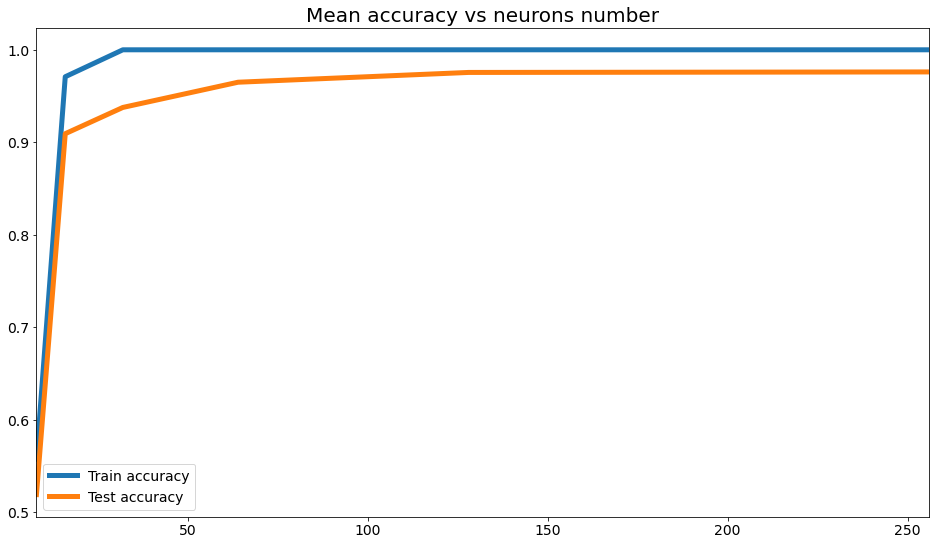

In [9]:
fig, ax = plt.subplots(figsize=(16,9))

for col in neurons_accuracies.columns:
    ax.plot(neurons_accuracies[col],
           lw=5)

#decorations
ax.set_xlim(8, 256)
ax.set_title('Mean accuracy vs neurons number', fontsize=20)
ax.tick_params(labelsize=14)
ax.legend(['Train accuracy', 'Test accuracy'],
         fontsize=14)

Our model's accuracy hit **1** pretty fast on train set while it's a bit lower on test set. But train accuracy is increasing with number of neurons in the hidden layer. It reaches **0.976** with **256** neurons but it's still worse than knn classification gave us. And there is still overfitting.

Would it be more effective to use more layers? Let's find out!

## Multilayer network

We'll start with one additional layer and use the same neurons numbers. Let's update `mlp_cross_val()` for that.

In [10]:
def mlp_cross_val(data, n, layers=1):
    #performs 4-fold cross validation using MLPClassifier
    #returns overall accuracy
    
    kf = KFold(n_splits=4,
              shuffle=True,
              random_state=0)
    
    train_accuracies = []
    test_accuracies = []
    
    #Create a tuple with n nerouns in layers
    hidden_layers = tuple([n for layer in range(layers)])
    
    for train_index, test_index in kf.split(data):
        
        train_set = data.iloc[train_index]
        test_set = data.iloc[test_index]
        
        mlp_class = MLPClassifier(hidden_layer_sizes=hidden_layers,
                                  solver='sgd',
                                  max_iter=300,
                                  learning_rate_init=0.02,
                                  random_state=0)
        
        mlp_class.fit(train_set.iloc[:, :-1], train_set['target'])
        
        #Use train or test sets in score() depending on how
        train_accuracy = mlp_class.score(train_set.iloc[:, :-1],
                                       train_set['target'])

        test_accuracy = mlp_class.score(test_set.iloc[:, :-1],
                                       test_set['target'])

        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        
    return np.mean(train_accuracies), np.mean(test_accuracies)

Now we'll use our function with different hyperparameters. And for that we'll create another func!

The `accurasies_plot_nn()` function will train NN with defined layers parameters and add resulting mean accuracy with NN hyperparameters to the `neurons_accuracies`. It will also build a "Mean accuracy vs neurons number" plot. 

In [11]:
def accurasies_plot_nn(data, layer, neurons):
    #Iterate over both methods and neurons
    for neuron in neurons:
        new_row = [layer, neuron]
        accuracies = mlp_cross_val(data, neuron, layer)
        new_row.extend(list(accuracies))
        neurons_accuracies.loc[len(neurons_accuracies)] = new_row
    
    #Build plot
    fig, ax = plt.subplots(figsize=(16,9))
    columns = ['train', 'test']
    layer_accuracies = neurons_accuracies[neurons_accuracies['layers'] == layer]
    
    for col in columns:
        ax.plot(layer_accuracies['neurons'], 
                layer_accuracies[col],
               lw=5)

    #decorations
    ax.set_xlim(8, 256)
    ax.set_title('Mean accuracy vs neurons number', fontsize=20)
    ax.tick_params(labelsize=14)
    ax.legend(['Train accuracy', 'Test accuracy'],
             fontsize=14,
             loc='lower right')

Also let's prepare `neurons_accuracies` dataframe.

In [12]:
#Modify accuracies df
neurons_accuracies.reset_index(inplace=True)
neurons_accuracies.rename(columns={'index': 'neurons'}, inplace=True)
neurons_accuracies.insert(0, "layers", 1)

neurons_accuracies.tail(6)

,layers,neurons,train,test
0,1,8,0.557243,0.51913
1,1,16,0.970872,0.909297
2,1,32,1.0,0.937674
3,1,64,1.0,0.964946
4,1,128,1.0,0.975518
5,1,256,1.0,0.976073


### Two hidden layers

Two hidden layers NN, here we go! 

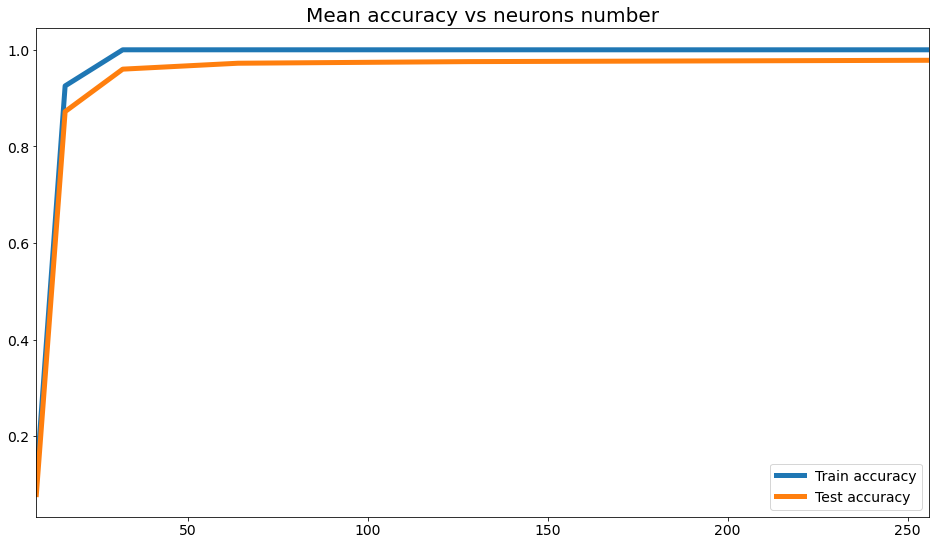

In [13]:
accurasies_plot_nn(digits.frame, 2, neurons)

In [14]:
neurons_accuracies.tail(6)

,layers,neurons,train,test
6,2.0,8.0,0.107957,0.079018
7,2.0,16.0,0.925229,0.872042
8,2.0,32.0,1.0,0.959937
9,2.0,64.0,1.0,0.972176
10,2.0,128.0,1.0,0.975516
11,2.0,256.0,1.0,0.978299


Our best shot brought us **0.978** accuracy with **256** neurons and it's the worst result so far for the NN.

### Three hidden layers

Let's try 3 hidden layers this time.

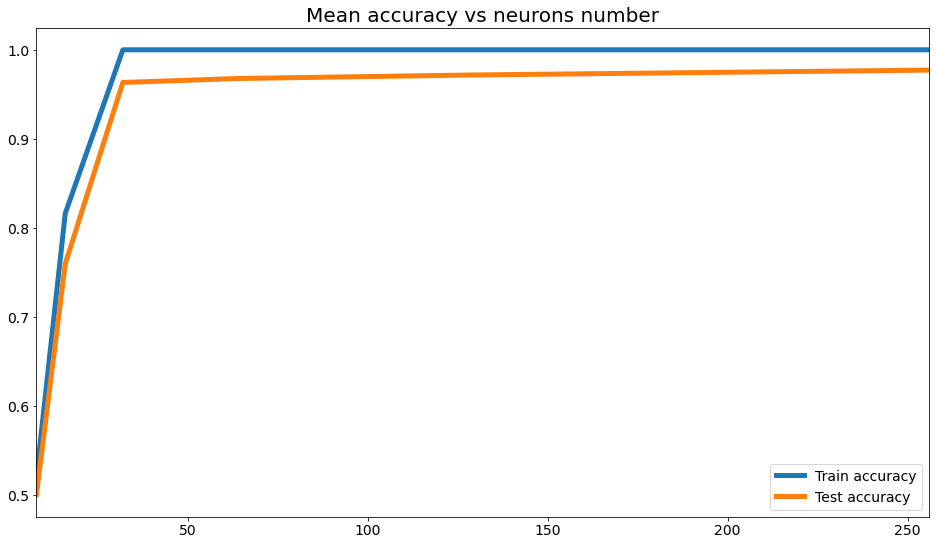

In [15]:
accurasies_plot_nn(digits.frame, 3, neurons)

In [16]:
neurons_accuracies.tail(6)

,layers,neurons,train,test
12,3.0,8.0,0.519841,0.500049
13,3.0,16.0,0.816016,0.759527
14,3.0,32.0,1.0,0.963275
15,3.0,64.0,1.0,0.967726
16,3.0,128.0,1.0,0.971622
17,3.0,256.0,1.0,0.977184


Using one additional layer doesn't improve accuracy at all and tends to overfitting. We should try different approach.

## Activation functions

MLPClassifier uses [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) by default. We can change it to [sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) and [hyperbolic tan function](https://en.wikipedia.org/wiki/Hyperbolic_functions). There is also identity function but we leave it.

We'll test both function with one hidden layer. Let's update our functions.

In [17]:
def mlp_cross_val(data, n, layers=1, func='relu'):
    #performs 4-fold cross validation using MLPClassifier
    #returns overall accuracy
    
    kf = KFold(n_splits=4,
              shuffle=True,
              random_state=0)
    
    train_accuracies = []
    test_accuracies = []
    
    #Create a tuple with n nerouns in layers
    hidden_layers = tuple([n for layer in range(layers)])
    
    for train_index, test_index in kf.split(data):
        
        train_set = data.iloc[train_index]
        test_set = data.iloc[test_index]
        
        mlp_class = MLPClassifier(hidden_layer_sizes=hidden_layers,
                                  max_iter=1100, #for sigmoid convergence
                                  solver='sgd',
                                  learning_rate_init=0.02,
                                  random_state=0,
                                  activation=func)
        
        mlp_class.fit(train_set.iloc[:, :-1], train_set['target'])
        
        #Use train or test sets in score() depending on how
        train_accuracy = mlp_class.score(train_set.iloc[:, :-1],
                                       train_set['target'])

        test_accuracy = mlp_class.score(test_set.iloc[:, :-1],
                                       test_set['target'])

        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        
    return np.mean(train_accuracies), np.mean(test_accuracies)

def accurasies_nn(data, layers, neurons, func='relu'):
    #Iterate over both methods and neurons and layers
    for layer in layers:
        for neuron in neurons:
            new_row = [layer, neuron]
            accuracies = mlp_cross_val(data, neuron, layer, func)
            new_row.extend(list(accuracies))
            new_row.append(func)
            neurons_accuracies.loc[len(neurons_accuracies)] = new_row      
            


def nn_plot(func):    
    #Build plots
    fig, axs = plt.subplots(3, 1, figsize=(16,18))
    plt.suptitle('Mean accuracies {} function'.format(func), size=26)
    columns = ['train', 'test']
    
    for i in range(3):
        #Filter our df
        mask = (neurons_accuracies['layers'] == (i + 1)) & (neurons_accuracies['func'] == func)
        layer_accuracies = neurons_accuracies[mask]
        
        for col in columns:
            axs[i].plot(layer_accuracies['neurons'], 
                       layer_accuracies[col],
                       lw=4)

            #decorations
            axs[i].set_xlim(8, 256)
            axs[i].set_title('{} hidden layers'.format(i + 1), fontsize=20)
            axs[i].tick_params(labelsize=14)
            axs[i].legend(['Train accuracy', 'Test accuracy'],
                         fontsize=14,
                         loc='lower right')

### Sigmoid func

In [18]:
neurons_accuracies['func'] = 'relu'

function = ['logistic', 'tanh']
layers = [1, 2 ,3]

accurasies_nn(digits.frame, layers, neurons, function[0])
neurons_accuracies.tail(18)

,layers,neurons,train,test,func
18,1.0,8.0,0.993879,0.930452,logistic
19,1.0,16.0,0.99796,0.953811,logistic
20,1.0,32.0,1.0,0.977747,logistic
21,1.0,64.0,1.0,0.97663,logistic
22,1.0,128.0,1.0,0.981641,logistic
23,1.0,256.0,1.0,0.982751,logistic
24,2.0,8.0,0.992024,0.915975,logistic
25,2.0,16.0,0.998887,0.957153,logistic
26,2.0,32.0,0.999629,0.967725,logistic
27,2.0,64.0,0.999444,0.972732,logistic


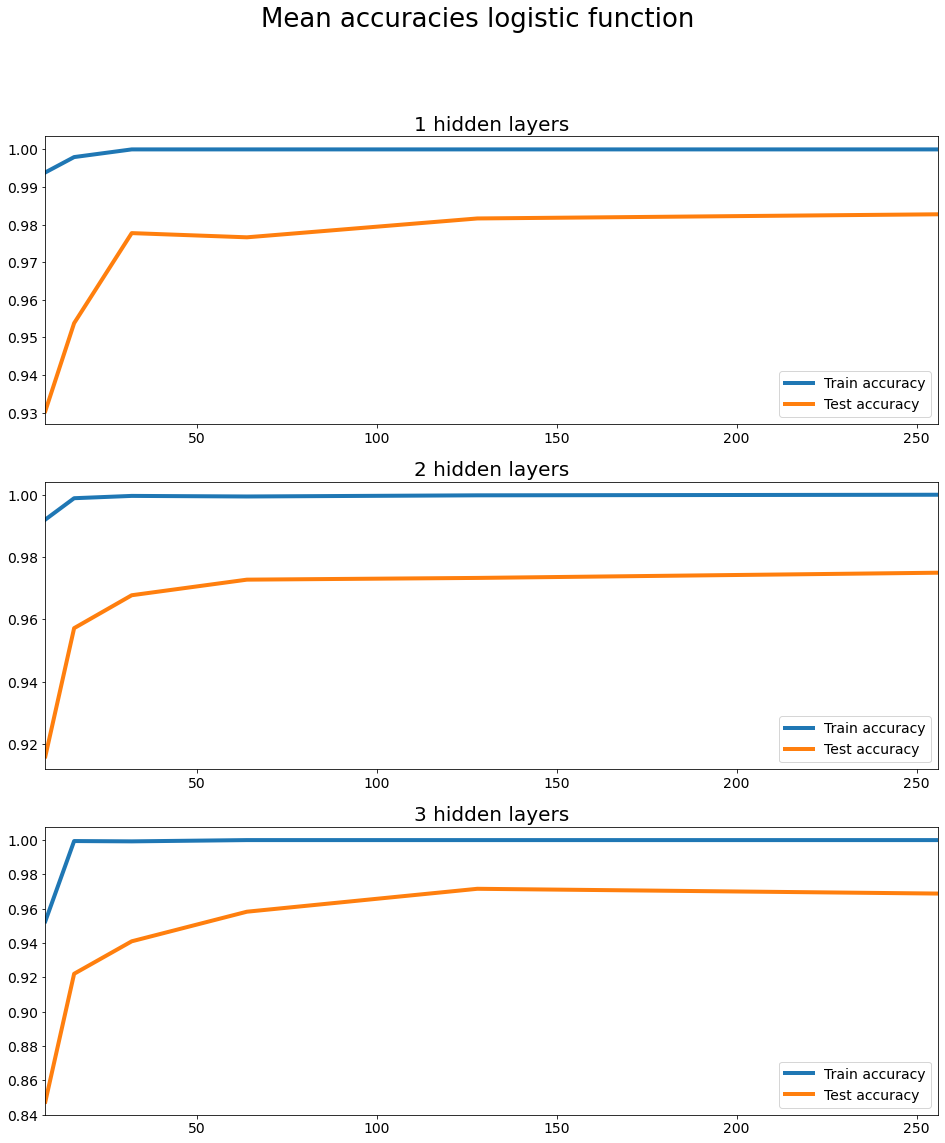

In [19]:
nn_plot(function[0])

### Tanh func

In [20]:
accurasies_nn(digits.frame, layers, neurons, function[1])
neurons_accuracies.tail(18)

,layers,neurons,train,test,func
36,1.0,8.0,0.982565,0.907069,tanh
37,1.0,16.0,0.997218,0.934342,tanh
38,1.0,32.0,1.0,0.963276,tanh
39,1.0,64.0,1.0,0.968843,tanh
40,1.0,128.0,1.0,0.978301,tanh
41,1.0,256.0,1.0,0.980525,tanh
42,2.0,8.0,0.879439,0.841952,tanh
43,2.0,16.0,0.998887,0.924876,tanh
44,2.0,32.0,1.0,0.960494,tanh
45,2.0,64.0,1.0,0.97162,tanh


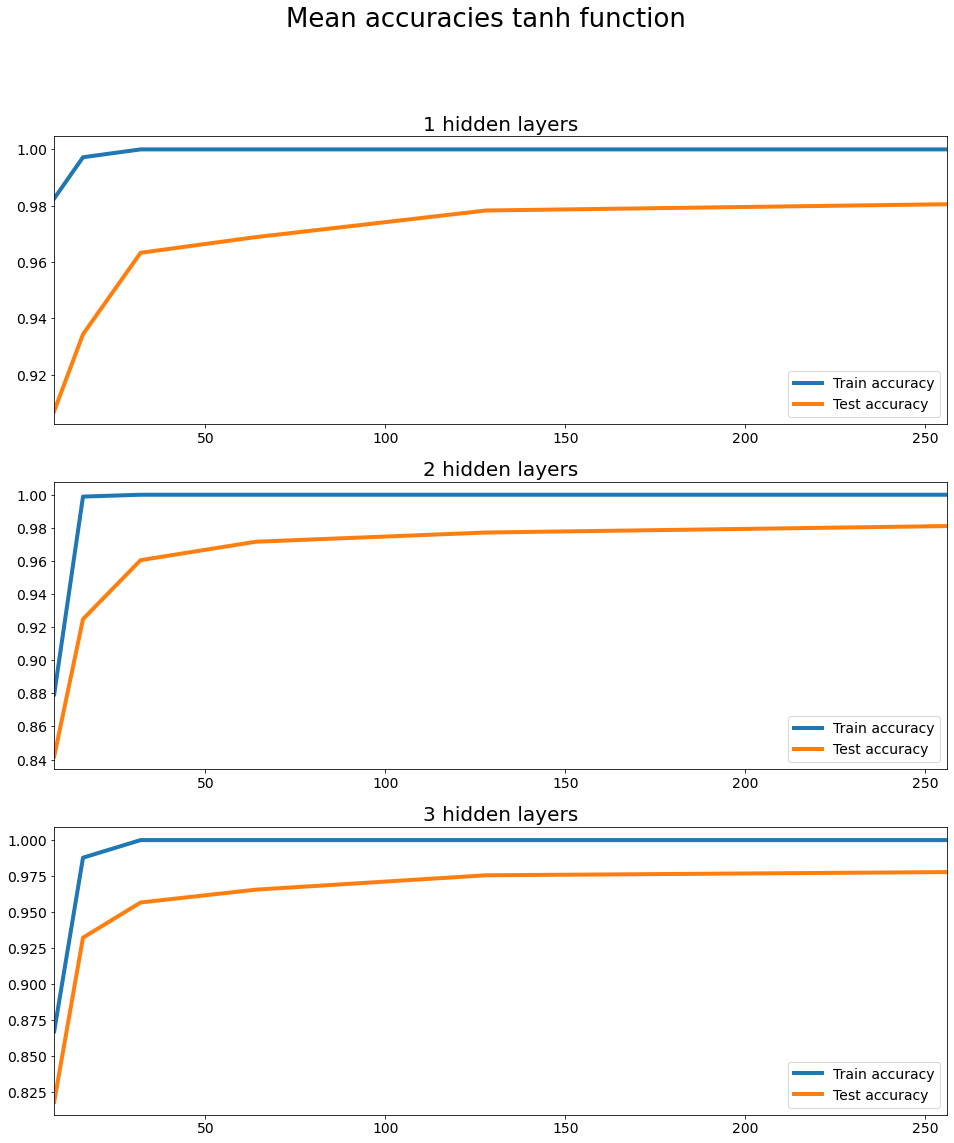

In [21]:
nn_plot(function[1])

Okay, we've tried all three activation functions so far and even beaten the KNN results. We've got **0.982** accuracy with **logistic** func and **1** hidden layers **256** neurons each.

But all our models seem to be too **"perfect"**, to be **overfitted**. Regardless of hyperparameters we're still getting train accuracies close to or even **equal 1**, while test accuracies are quite lower. This gap decreases with increasing complexity of NN (especially tanh) but it doesn't solve our problem.

Our best results are down below.

In [22]:
neurons_accuracies.groupby(['func', 'layers'])['test'].max()

func      layers
logistic  1.0       0.982751
          2.0       0.974959
          3.0       0.971620
relu      1.0       0.976073
          2.0       0.978299
          3.0       0.977184
tanh      1.0       0.980525
          2.0       0.981078
          3.0       0.977744
Name: test, dtype: float64

## Grid Search

We've tried to find our best hyperparameters by manually iterating over them until now. But `sklearn` has wonderful `GridSearchCV` class that make it on his own.

Let's try it with the previous sets of hyperparameters.

In [100]:
from sklearn.model_selection import GridSearchCV

#Prepare hidden layers config
hdn = []

for layers in range(1,4):
    for n in neurons:
        hidden_layer = tuple([n for layer in range(layers)])
        hdn.append(hidden_layer)
        
#function.append('relu')

parameter_space = {'hidden_layer_sizes': hdn,
                  'activation': function}

mlp = MLPClassifier(max_iter=1100,
                    solver='sgd',
                    learning_rate_init=0.02,
                    random_state=0)

kf = KFold(n_splits=4,
           shuffle=True,
           random_state=0)

clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=kf)
clf.fit(digits.data, digits.target)

print(clf.best_params_, clf.best_score_)

{'activation': 'logistic', 'hidden_layer_sizes': (256,)} 0.9827505567928732


Grid search results are exact the same with much easier pipeline:

* **0.982** accuracy
* **128**
* **1** layer
* **logistic** activation function

But we still have overfitting problem to solve.

## L2 regularization

Now we'll use our ultimate weapon - [L2 regularization](https://towardsdatascience.com/intuitions-on-l1-and-l2-regularisation-235f2db4c261).

MLPClassifier has special parameter `alpha` for that which we'll be manually changing. Let's first update the `mlp_cross_val()`.

In [40]:
def mlp_cross_val(data, n=8, layers=1, func='relu', alpha=0.0001):
    #performs 4-fold cross validation using MLPClassifier
    #returns overall accuracy
    
    kf = KFold(n_splits=4,
              shuffle=True,
              random_state=0)
    
    train_accuracies = []
    test_accuracies = []
    
    #Create a tuple with n nerouns in layers
    hidden_layers = tuple([n for layer in range(layers)])
    
    for train_index, test_index in kf.split(data):
        
        train_set = data.iloc[train_index]
        test_set = data.iloc[test_index]
        
        mlp_class = MLPClassifier(hidden_layer_sizes=hidden_layers,
                                  max_iter=1100,
                                  learning_rate_init=0.02,
                                  random_state=0,
                                  activation=func,
                                  alpha=alpha)
        
        mlp_class.fit(train_set.iloc[:, :-1], train_set['target'])
        
        #Use train or test sets in score() depending on how
        train_accuracy = mlp_class.score(train_set.iloc[:, :-1],
                                       train_set['target'])

        test_accuracy = mlp_class.score(test_set.iloc[:, :-1],
                                       test_set['target'])

        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        
        return np.mean(train_accuracies), np.mean(test_accuracies)

We'll iterate alpha with the hidden layers parameters that gave us the best test accuracy which is:
* **0.982** accuracy
* **256**
* **1** layer
* **logistic** activation function

Let's try to fight overfitting!

In [24]:
#Prepare alpha values and special df
alphas = np.linspace(0.0001, 5, 200)

alpha_df = pd.DataFrame({'layers': 1,
                         'neurons': 256,
                         'alpha': alphas,
                         'train': np.nan,
                         'test': np.nan})

#Iterate through alpha values
for alpha in alphas:
    accuracies = mlp_cross_val(digits.frame, 256,
                             func='logistic',
                             alpha=alpha)
    
    alpha_df.loc[alpha_df['alpha'] == alpha, 'train'] = accuracies[0]
    alpha_df.loc[alpha_df['alpha'] == alpha, 'test'] = accuracies[1]
        
alpha_df.tail()

,layers,neurons,alpha,train,test
195,1,256,4.899499,0.954714,0.951111
196,1,256,4.924625,0.945805,0.931111
197,1,256,4.949750,0.949517,0.935556
198,1,256,4.974875,0.946548,0.940000
199,1,256,5.000000,0.950260,0.940000


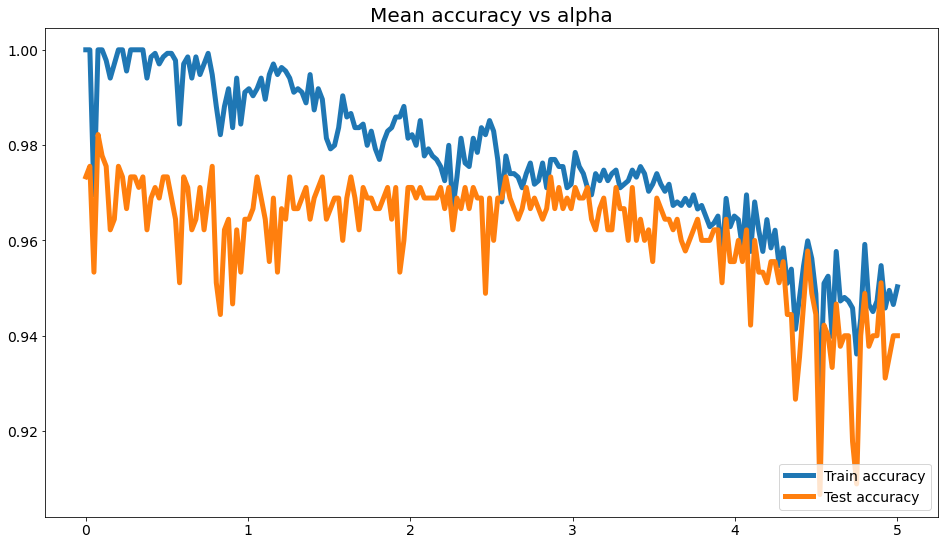

In [25]:
fig, ax = plt.subplots(figsize=(16,9))
columns = ['train', 'test']
    
for col in columns:
    ax.plot(alpha_df['alpha'], 
            alpha_df[col],
            lw=5)

#Decorations
ax.set_title('Mean accuracy vs alpha', fontsize=20)
ax.tick_params(labelsize=14)
ax.legend(['Train accuracy', 'Test accuracy'],
            fontsize=14,
            loc='lower right')

When alpha is somewher between 2 and 4 train accuracy decreases to test one which is almost on the same level from initial alpha.

Let's explore this interval.

In [68]:
alpha_mask = (alpha_df['alpha'] >= 2) & (alpha_df['alpha'] <= 4)

alpha_df[alpha_mask].sort_values('test', ascending=False).head(10)

,layers,neurons,alpha,train,test
114,1,256,2.864364,0.976986,0.973333
103,1,256,2.587988,0.977728,0.973333
80,1,256,2.010110,0.982183,0.971111
93,1,256,2.336737,0.976244,0.971111
134,1,256,3.366867,0.974759,0.971111
130,1,256,3.266366,0.974759,0.971111
123,1,256,3.090490,0.971047,0.971111
116,1,256,2.914615,0.975501,0.971111
108,1,256,2.713614,0.974016,0.971111
95,1,256,2.386987,0.981440,0.971111


We've got some intresting results. Two models have slightly higher test accuracy which means we're about over regularization. For example **123** iteration with the difference is **-0.000064**. It's sign of over regularization.

We'll take **114** row as our best.

In [84]:
best_alpha = alpha_df.iloc[114, 2]

alpha_df.iloc[114, :]

layers       1.000000
neurons    256.000000
alpha        2.864364
train        0.976986
test         0.973333
Name: 114, dtype: float64

Now we can say for sure that which hyperparameters we should use.

## Visualization of MLP Weights

In this paragraph we'll research visualization of MLP weights using [sklearn article](https://scikit-learn.org/stable/auto_examples/neural_networks/plot_mnist_filters.html) as example. Weights picture can give us some insights about neural network behavior.

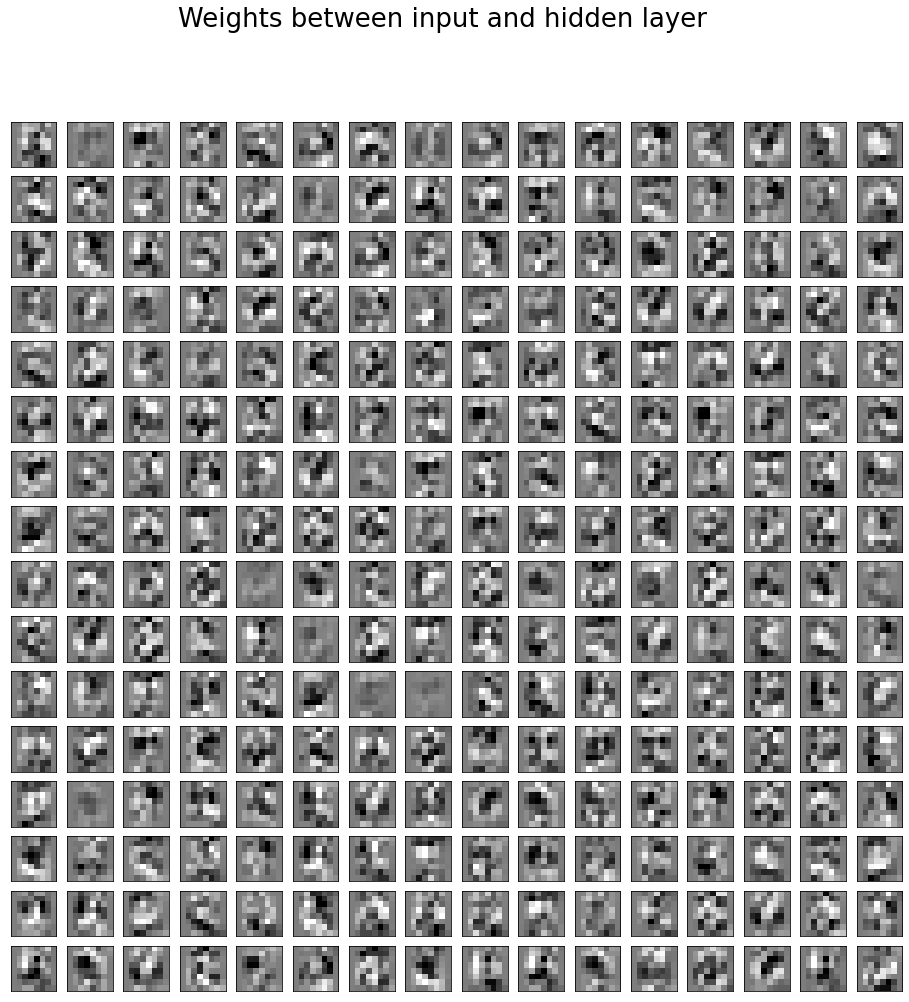

In [128]:
from sklearn.model_selection import train_test_split

#MLP with best hp
mlp = MLPClassifier(hidden_layer_sizes=(256,),
                    activation='logistic',
                    max_iter=1100,
                    alpha=best_alpha,
                    solver='sgd',
                    random_state=0,
                    learning_rate_init=0.02)

X_train, X_test, y_train, y_test = train_test_split(
    digits.data, digits.target, test_size=0.25, random_state=0)

mlp.fit(X_train, y_train)

fig, axes = plt.subplots(16, 16, figsize=(16,16))
plt.suptitle('Weights between input and hidden layer', size=26)

#Use global min/max to ensure all weights are shown on the same scale
vmin, vmax = mlp.coefs_[0].min(), mlp.coefs_[0].max()

for coef, ax in zip(mlp.coefs_[0].T, axes.ravel()):
    ax.matshow(coef.reshape(8, 8), cmap=plt.cm.gray, vmin=.5 * vmin,
               vmax=.5 * vmax)
    ax.set_xticks(())
    ax.set_yticks(())

Weights look very structured. We even can see something like numbers in there. This is a good sign of model perfomance.

## Conclusions

In this project we've researched how MLP classifier behaves with different hyperparameters. We've tried 

We've seen that making neural network more complex doesn't necessarily improve predictions. Actually it makes the opposite and tends to overfitting.

We've used powerful L2 regularization to fight it and succeeded. Finally we've built weights picture which uncovers network hidden work.   

Further we could add made some more improvements to the model like momemntum or early stopping and test it. Also we could experiment with folds number.